# Continuing with DICOM
> Further understanding DICOM and using fastai to work with DICOM

- toc:true
- branch: master
- badges: true
- comments: true
- author: Mohamed Arshath
- categories: [DICOM, medical images, fastai]

In this blog, we will largely use Jeremy Howard's series of [notebooks](https://www.kaggle.com/jhoward/notebooks) on Kaggle to understand DICOM and to learn how to use fastai.medical to work with DICOM files. I would highly encourage going through Jeremy's blogs. Here, I will be merely be blogging as I learn and practice his notebooks. 

There are five notebooks in this series. In this blog, we will go through the first four notebooks. 
1. [Creating a metadata DataFrame](https://www.kaggle.com/jhoward/creating-a-metadata-dataframe-fastai) - In this notebook, we will learn how to create a DataFrame from DICOM metadata

2. [Some DICOM gotchas to be aware of](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai) - Here, we will learn some things to watch out for when working with DICOM like signed data being used as if it were unsigned

3. [Don't see like a radiologist](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai) - Radiologists, as we will learn below, use windowing to observe different area of interest such as brain, subdural because humans are limited in their ability to distinguish different contrast levels. This human limitations does not affect macines. In this notebook, we will learn how we can prepare (normalize) our images to help our model learn better. 

4. [Cleaning the data for rapid prototyping](https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai) - We will put our learnings into action by preparing a prototyping dataset. We will clean the data and then make a smaller set of smaller JPEG images for prototyping.  

5. [From prototyping to submission](https://www.kaggle.com/jhoward/from-prototyping-to-submission-fastai) - In this final notebook, we will learn to use our prototype dataset in building a classifier then learn to use full scale dataset to train our classifier. *not covered in this blog*

# Importing 

In [1]:
from fastai.basics           import *
from fastai.vision.all       import *
from fastai.medical.imaging  import *
import seaborn as sns

# Creating a metadata dataframe

The [first notebook](https://www.kaggle.com/jhoward/creating-a-metadata-dataframe-fastai) show us how to make a dataframe from `dcm` files. 

In [2]:
path_dest = Path('./')

In [3]:
path = Path('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection')

In [4]:
path_trn = path/'stage_2_train'
fns_trn = path_trn.ls()

In [5]:
path_tst = path/'stage_2_test'
fns_tst = path_tst.ls()

In [6]:
fn = fns_trn[0]
dcm = fn.dcmread()
dcm

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 10000000300633
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'RSNA Challenge 2019'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_27a354d42
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_907f00d7'
(0020, 000d) Study Instance UID                  UI: ID_f69dbbd67a
(0020, 000e) Series Instance UID                 UI: ID_8408ebcd9f
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: [-125, -18, 111.900024]
(0020, 0037) Image Orientation (Patient)         DS: [1, 0, 0, 0, 1, 0]
(0028, 0002) Samp

Looking at an example `dcm` file we can see that we have seen and cover most of the data elements in our previous blog except `Window Center`, `Window Width`, `Rescale Intercept` and ` Rescale Slope`. We will focus on them.

`(0028, 1050) Window Center` and 
`(0028, 1051) Window Width`  
The grayscale values of a CT is made up of a range of pixel values. Since they are either 12-bit or 16-bit, the range of possible values are  0-4096 (for 12-bit) and 0-65536 (for 16-bit). This is in comparison to a normal 8-bit images whose values range between 0-255. The larger the range, larger is the levels of contrast. Our human eyes are merely good at contrasting 100 levels of contrast. A 12-bit image would therefore provide 4096 contrast levels which could be difficult for humans to differentiate. Hence, in CTs, it is normal to choose a range of value to observe. The midlevel of the range is the `Window Center` and the range is `Window Level`.  We can also think of varying `Window Center` as varying the brighness and varying the `Window Level` as varying the contrast. 

fastai provides the `Window Level` and `Window Center` for observing different area of interest. Let's take a look at few

In [7]:
dicom_windows

namespace(brain=(80, 40),
          subdural=(254, 100),
          stroke=(8, 32),
          brain_bone=(2800, 600),
          brain_soft=(375, 40),
          lungs=(1500, -600),
          mediastinum=(350, 50),
          abdomen_soft=(400, 50),
          liver=(150, 30),
          spine_soft=(250, 50),
          spine_bone=(1800, 400))

In [8]:
dicom_windows.brain

(80, 40)

In [9]:
dicom_windows.subdural

(254, 100)

Let's use fastai functionality to see some of these images under different windowing.

>Note: We will learn about normalized windowing later in the blog

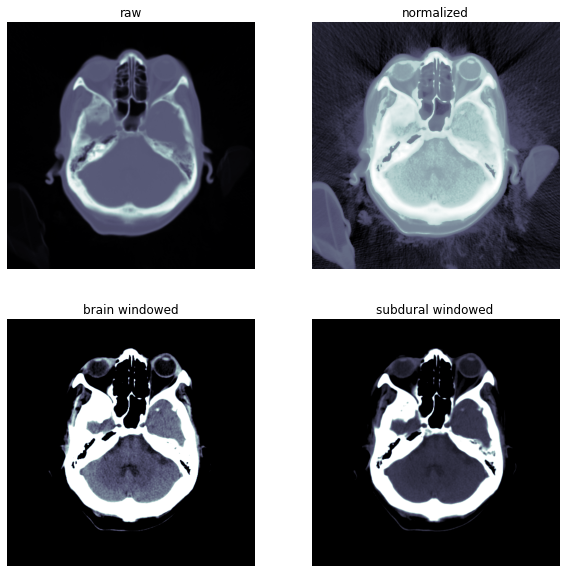

In [10]:
scales = False, True, dicom_windows.brain, dicom_windows.subdural
titles = 'raw','normalized','brain windowed','subdural windowed'
for s,a,t in zip(scales, subplots(2,2,imsize=5)[1].flat, titles):
    dcm.show(scale=s, ax=a, title=t)

`Rescale Intercept` and `Rescale Slope`
Now, let's move to understanding `Rescale Intercept` and `Rescale Slope`. The concept is pretty simple. DICOM uses linear transformation to save pixel values when stored on disk  and when it is moved to memory.   

`y = mx + c`

`m` is the `Rescale Slope` and `c` is the `Rescale Intercept`. 

Why is this linear transformation needed? 
CT scans are meaured in Hounsfield Units which can be negative and they are stored as `unsigned integers` format which goes from `0` and above. Hence, a linear transformation is needed to shift the range of values.   


Now that we have understood some of the important data elements. Let's prepare the dataframes so it would be easier to work with. fastai/pydicom provides really easy way to convert DICOM to dataframe. 

> Note: Preparing these dataframes from DICOM takes really long. When I ran it on Kaggle, it took about 8 hours to make df_trn and df_tst below.

In [11]:
def save_lbls():
    path_lbls = path/'stage_2_train.csv'
    lbls = pd.read_csv(path_lbls)
    lbls[["ID","htype"]] = lbls.ID.str.rsplit("_", n=1, expand=True)
    lbls.drop_duplicates(['ID','htype'], inplace=True)
    pvt = lbls.pivot('ID', 'htype', 'Label')
    pvt.reset_index(inplace=True)    
    pvt.to_feather('labels.fth')

In [12]:
#save_lbls()

In [13]:
#df_lbls = pd.read_feather('labels.fth').set_index('ID')
#df_lbls.head(8)

In [14]:
#df_lbls.mean()

In [15]:
#%time df_tst = pd.DataFrame.from_dicoms(fns_tst, px_summ=True)
#df_tst.to_feather('df_tst.fth')
#df_tst.head()

In [16]:
#%time df_trn = pd.DataFrame.from_dicoms(fns_trn, px_summ=True)
#df_trn.to_feather('df_trn.fth')

# Some DICOM gotchas to be aware of

From here, we will work on Jeremy's "[Some DICOM gotchas to be aware of](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai)".

In [17]:
path_df = Path('../input/dataframes')
path_df.ls()

(#3) [Path('../input/dataframes/df_tst.fth'),Path('../input/dataframes/labels.fth'),Path('../input/dataframes/df_trn.fth')]

In [18]:
df_lbls = pd.read_feather(path_df/'labels.fth')
df_tst = pd.read_feather(path_df/'df_tst.fth')
df_trn = pd.read_feather(path_df/'df_trn.fth')

We merge the `df_lbls` dataframe with `df_trn`.

In [19]:
comb = df_trn.join(df_lbls.set_index('ID'), 'SOPInstanceUID')
assert not len(comb[comb['any'].isna()])

In [20]:
comb.head(10)

SOPInstanceUID Modality    PatientID StudyInstanceUID SeriesInstanceUID  \
0   ID_27a354d42       CT  ID_907f00d7    ID_f69dbbd67a     ID_8408ebcd9f   
1   ID_9ef779a18       CT  ID_8bca9b69    ID_ed4776c4b6     ID_073c18243c   
2   ID_5bed38bf6       CT  ID_b501522f    ID_906af9ca62     ID_719a4e6a78   
3   ID_286599272       CT  ID_7ba59d14    ID_9f39f65610     ID_b55ce168f2   
4   ID_bba76cea8       CT  ID_32c07778    ID_f9641021e5     ID_e04ed2ad5c   
5   ID_a917377cd       CT  ID_e4488e09    ID_f13c83c8ae     ID_91366e3a6e   
6   ID_7723b03a6       CT  ID_a329da04    ID_cd9053516e     ID_37b71d633c   
7   ID_dbb1cc814       CT  ID_afd8ebfe    ID_55af39ec1b     ID_eb25c44049   
8   ID_4b08fe185       CT  ID_6338c4f1    ID_a3b607ba3f     ID_468e9dedde   
9   ID_8192d735e       CT  ID_b4a5aa19    ID_3f35938aea     ID_1ff3a48327   

  StudyID  ImagePositionPatient  ImageOrientationPatient  SamplesPerPixel  \
0                   -125.000000                      1.0                1   
1                   -125.000000                      1.0                1   
2                   -125.000000                      1.0                1   
3                   -137.500000                      1.0                1   
4                   -122.000000                      1.0                1   
5                   -107.800003                      1.0                1   
6                   -125.000000                      1.0                1   
7                   -107.000000                      1.0                1   
8                   -125.000000                      1.0                1   
9                   -132.000000                      1.0                1   

  PhotometricInterpretation  ...  img_max    img_mean      img_std  \
0               MONOCHROME2  ...     2671  454.914642   616.514427   
1               MONOCHROME2  ...     2778 -330.188461  1415.697408   
2               MONOCHROME2  ...     2687 -128.333286   678.065725   
3               MONOCHROME2  ...     2568  396.514767   528.022874   
4               MONOCHROME2  ...     2413  521.192650   568.400446   
5               MONOCHROME2  ...     2756  -90.590172  1140.209042   
6               MONOCHROME2  ...     2732 -308.353733   949.515538   
7               MONOCHROME2  ...     2374  448.588409   488.864187   
8               MONOCHROME2  ...     3082   66.582775  1203.552054   
9               MONOCHROME2  ...     2612  471.477554   578.011862   

   img_pct_window  any  epidural  intraparenchymal  intraventricular  \
0        0.149364    0         0                 0                 0   
1        0.266693    1         0                 1                 0   
2        0.004173    0         0                 0                 0   
3        0.107368    0         0                 0                 0   
4        0.263206    0         0                 0                 0   
5        0.115768    0         0                 0                 0   
6        0.008362    0         0                 0                 0   
7        0.126221    0         0                 0                 0   
8        0.235271    0         0                 0                 0   
9        0.277931    0         0                 0                 0   

   subarachnoid  subdural  
0             0         0  
1             1         1  
2             0         0  
3             0         0  
4             0         0  
5             0         0  
6             0         0  
7             0         0  
8             0         0  
9             0         0  

[10 rows x 48 columns]

## Looking at BitsStored and PixelRepresentation

**Recap**

`BitsStored` - Tells whether the data is stored in 12 or 16 bits

`PixelRepresentation` - Tells if the data it is signed or unsigned data. Signed data can have negative pixels while unsigned starts from 0 and above.

In [21]:
repr_flds = ['BitsStored','PixelRepresentation']
comb.pivot_table(values=['img_mean','img_max','img_min','PatientID','any'], index=repr_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min','PatientID':'count','any':'mean'})

PatientID       any  img_max    img_mean  \
BitsStored PixelRepresentation                                             
12         0                       333443  0.128409     4095  451.058719   
           1                         2312  0.335640     2047 -639.495079   
16         1                       417048  0.154275    32767   41.121570   

                                img_min  
BitsStored PixelRepresentation           
12         0                          0  
           1                      -2048  
16         1                     -32768

We can see that that when `PixelRepresentation` is 1, meaning the data type is signed, `img_min` can take negative values. Largely, we will be working with unsigned 12-bit data and signed 16-bit data. 

As we saw earlier `RescaleIntercept` and `RescaleSlope` tell us how to scale our data. Let's take a look.

In [22]:
comb.pivot_table(values=['WindowCenter','WindowWidth', 'RescaleIntercept', 'RescaleSlope'], index=repr_flds,
                   aggfunc={'mean','max','min','std','median'})

RescaleIntercept                               \
                                            max         mean  median     min   
BitsStored PixelRepresentation                                                 
12         0                                1.0 -1023.141245 -1024.0 -1024.0   
           1                                0.0     0.000000     0.0     0.0   
16         1                                0.0 -1016.754254 -1024.0 -1024.0   

                                          RescaleSlope                        \
                                      std          max mean median  min  std   
BitsStored PixelRepresentation                                                 
12         0                    19.947663          1.0  1.0    1.0  1.0  0.0   
           1                     0.000000          1.0  1.0    1.0  1.0  0.0   
16         1                    85.832168          1.0  1.0    1.0  1.0  0.0   

                               WindowCenter                          \
                                        max       mean median   min   
BitsStored PixelRepresentation                                        
12         0                          650.0  37.940949   36.0  25.0   
           1                          350.0  48.775952   40.0  40.0   
16         1                          800.0  33.426668   30.0  25.0   

                                          WindowWidth                     \
                                      std         max        mean median   
BitsStored PixelRepresentation                                             
12         0                    19.130654      4095.0   85.132092   80.0   
           1                    47.549496      4000.0  179.653979   80.0   
16         1                    19.091547      3000.0  100.568292   80.0   

                                                  
                                 min         std  
BitsStored PixelRepresentation                    
12         0                    26.0  127.766167  
           1                    80.0  603.265211  
16         1                    60.0   95.569248

Firstly, we know that CT scans are measured in Hounsfield Units (HU) which takes both negative and positive values. HU measures the radiodensity (how much radiation is absorbed) by differnt materials such as air, fats, bones. Some radiodensity values of different materials are Air -100 HU; Fat -120 to -90 HU; Bone (Cortical) +500 to +1900

Based on this, we expect the mean `RescaleIntercept` for `PixelRepresentation` 0 to be around -1,024 but in our case there seem to be some with `RescaleIntercept` not equlas to -1,024.

The issue here could be that some of the images were `signed` data but were treated as `unsigned`. Later we will look at how to deal with them. 

Now, lets take a look `scaled_px` function that fastai provides to easliy scale pixels based on their `RescaleIntercept` and `RescaleSlope`

In [23]:
dcm = path_trn.ls(1)[0].dcmread()

In [24]:
dcm.pixels

tensor([[24., 22., 22.,  ..., 21., 17., 17.],
        [25., 25., 23.,  ..., 21., 20., 18.],
        [26., 27., 25.,  ..., 21., 20., 21.],
        ...,
        [17., 18., 19.,  ..., 19., 19., 20.],
        [23., 22., 21.,  ..., 20., 21., 21.],
        [22., 21., 20.,  ..., 20., 20., 20.]])

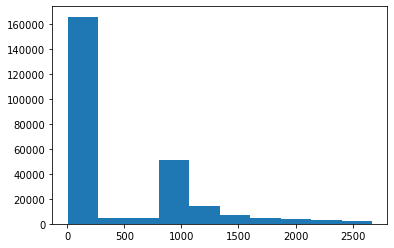

In [25]:
plt.hist(dcm.pixels.flatten().numpy());

In [26]:
dcm.scaled_px

tensor([[-1000., -1002., -1002.,  ..., -1003., -1007., -1007.],
        [ -999.,  -999., -1001.,  ..., -1003., -1004., -1006.],
        [ -998.,  -997.,  -999.,  ..., -1003., -1004., -1003.],
        ...,
        [-1007., -1006., -1005.,  ..., -1005., -1005., -1004.],
        [-1001., -1002., -1003.,  ..., -1004., -1003., -1003.],
        [-1002., -1003., -1004.,  ..., -1004., -1004., -1004.]])

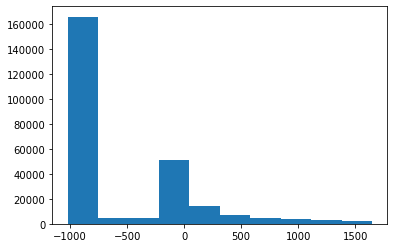

In [27]:
plt.hist(dcm.scaled_px.flatten().numpy());

# DON'T see like a radiologist!

Next, we will work on Jeremy's "[DON'T see like a radiologist!](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai)" notebook.

In this notebook, Jeremy's presents an idea as to how to help our model see better. We have seen earlier `windowing` is used to help radiologists to vary contrast and brightness to observe difffernt areas of interests such as the brain and the subdural. The reason for `windowing` is humans are only able to contrast about 100 levels of contrast gradient but a 16-bit CT has 2^16 (65,536) levels of contrast gradient. This is beyond a human's ability to distinguish hence windowning is used but this is not a problem for computer.  

Let's see an image without `windowing` vs `brain_window`.


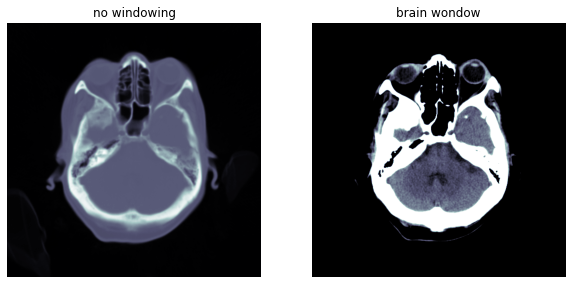

In [28]:
fname = path_trn.ls(10)[0]
_, axes = plt.subplots(1, 2, figsize=(10,8))
dcm = fname.dcmread()

for ax, name, window in zip(axes.flat, ['no windowing', 'brain wondow'], [None, dicom_windows.brain]):
    dcm.show(scale=window, ctx=ax, title=name)

This limitations of number of contrast gradient is not at all an issue for computer but we do have to rescale to help our models. Let's take a look at Jeremy's proposal. Let's see the rescaling.

<AxesSubplot:ylabel='Count'>

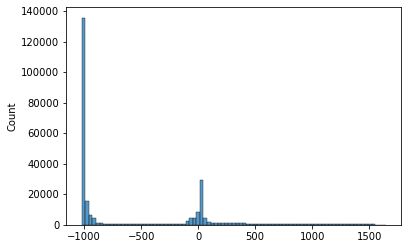

In [29]:
px = dcm.scaled_px.flatten()
sns.histplot(px)

We see a highly bimodal distribution. Background pixels are around -1000, and the brain tissue pixels are around 0. The proposal is to use non-linear mapping designed to give us an equal number of pixels in each range. Let's see how that is done. 

<AxesSubplot:ylabel='Count'>

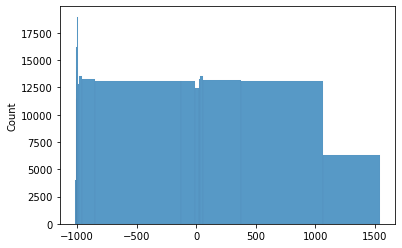

In [30]:
bins = px.freqhist_bins(20)
sns.histplot(dcm.scaled_px.flatten(), bins=bins)

'fastai.medical.imaging' can apply that non-linear mapping for you. In fact, this is the default way of displaying a DICOM in fastai. This is the normalized windowing we saw earlier. 

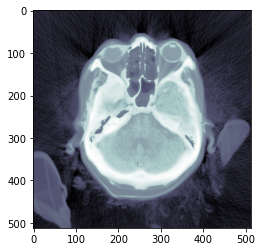

In [31]:
plt.imshow(dcm.hist_scaled(), cmap=plt.cm.bone);

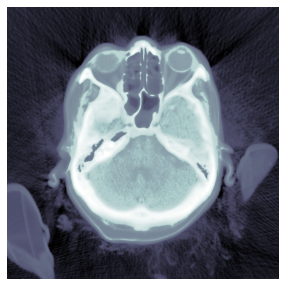

In [32]:
dcm.show()

## Creating a normalised dataset

Now that we know how to scale our dcm, let's take a look at preparing our dataset. Because the non-linear mapping we used varies from image to image, we will need to create a mapping that is appropriate for a wide range of images.

We will create a mapping for three different groups of images we saw earlier.

In [33]:
df1 = comb.query('(BitsStored==12) & (PixelRepresentation==0)')
df2 = comb.query('(BitsStored==12) & (PixelRepresentation==1)')
df3 = comb.query('BitsStored==16')
dfs = L(df1,df2,df3)

To create the bins
1. we will grab a random image with each label (`htypes`) and one with no labels for all the three groups above
2. then we will read the dcm
3. put them into a tensor
4. get the bins from this set of images
5. use the bins in `hist_scaled_px` to get the scaled float tensor, which we can pass to our model

In [34]:
htypes = 'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'

def get_samples(df):
    recs = [df.query(f'{c}==1').sample() for c in htypes]
    recs.append(df.query('any==0').sample())
    return pd.concat(recs).fname.values

sample_fns = concat(*dfs.map(get_samples))

In [35]:
sample_dcms = L(Path(o).dcmread() for o in sample_fns)
samples = torch.stack(tuple(sample_dcms.attrgot('scaled_px')))
samples.shape

torch.Size([21, 512, 512])

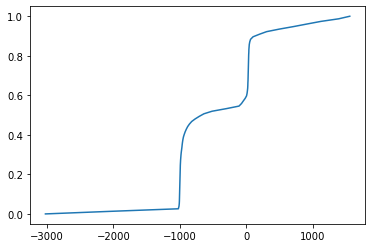

In [36]:
bins = samples.freqhist_bins()
plt.plot(bins, torch.linspace(0,1,len(bins)));

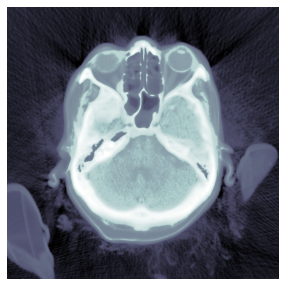

In [37]:
dcm.show(bins)

In [38]:
dcm.hist_scaled(bins), dcm.hist_scaled(bins).shape 

(tensor([[0.1558, 0.1299, 0.1299,  ..., 0.1169, 0.0649, 0.0649],
         [0.1688, 0.1688, 0.1429,  ..., 0.1169, 0.1039, 0.0779],
         [0.1818, 0.1948, 0.1688,  ..., 0.1169, 0.1039, 0.1169],
         ...,
         [0.0649, 0.0779, 0.0909,  ..., 0.0909, 0.0909, 0.1039],
         [0.1429, 0.1299, 0.1169,  ..., 0.1039, 0.1169, 0.1169],
         [0.1299, 0.1169, 0.1039,  ..., 0.1039, 0.1039, 0.1039]]),
 torch.Size([512, 512]))

Since the non-linear mapping results in a almost uniform distribution between 0 and 1, we wont have a mean and std of 0 and 1.

In [39]:
scaled_samples = torch.stack(tuple(o.hist_scaled(bins) for o in sample_dcms))
scaled_samples.mean(),scaled_samples.std()

(tensor(0.4080), tensor(0.2989))

# Cleaning the data for rapid prototyping

In this [notebook](https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai), we learn 
1. how to fix images with incorrect `RescaleIntercept`
2. removing images with minimal useful information
3. make a smaller dataset that we can use for prototyping
4. crop images to just contain the brain area
5. carry out histogram rescaling and save it as JPEG

The idea, apart from fixing incorrect images, is to create a dataset for rapid prototyping.

## Fixing incorrect RescaleIntercept

The problematic images were found in our df1.

In [40]:
df1 = comb.query('(BitsStored==12) & (PixelRepresentation==0)')

In [41]:
def df2dcm(df): return L(Path(o).dcmread() for o in df.fname.values)

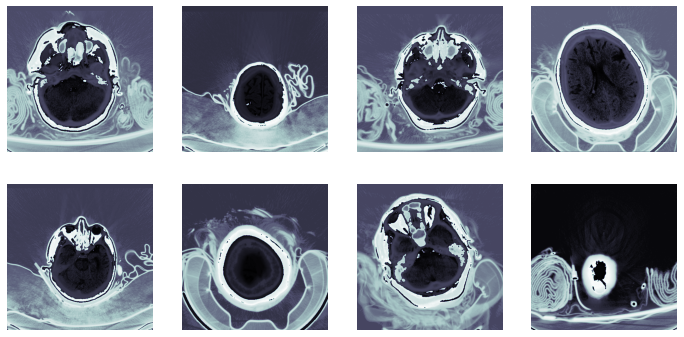

In [42]:
df_iffy = df1[df1.RescaleIntercept>-100]
dcms = df2dcm(df_iffy)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): dcms[i].show(ax=ax)

That does not look good at all.

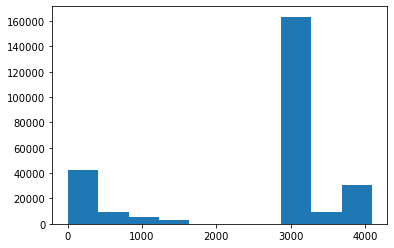

In [43]:
dcm = dcms[2]
d = dcm.pixel_array
plt.hist(d.flatten());

As explained previously, the mode for unsigned data appears around 0 but in our case the mode appears around 3000. This could be because signed data could have been treated as if it were unsigned data. As explained by Jeremy


>My guess is that what happened in the "iffy" images is that they were actually signed data, >but were treated as unsigned. If that's the case, the a value of -1000 or -1024 (the usual >values for background pixels in signed data images) will have wrapped around to 4096->1000=3096. So we'll need to shift everything up by 1000, then move the values larger than >2048 back to where they should have been.


The fix is 
1. add all pixel values by +1000 
2. for values more than 4096, -1000 
3. set RescaleIntercept to -1000

In [44]:
d += 1000

px_mode = scipy.stats.mode(d.flatten()).mode[0]
d[d>=px_mode] = d[d>=px_mode] - px_mode
dcm.PixelData = d.tobytes()
dcm.RescaleIntercept = -1000

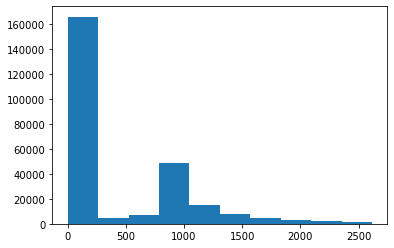

In [45]:
plt.hist(dcm.pixel_array.flatten());

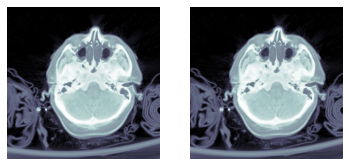

In [46]:
_,axs = subplots(1,2)
dcm.show(ax=axs[0]);   dcm.show(dicom_windows.brain, ax=axs[1])

In [47]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

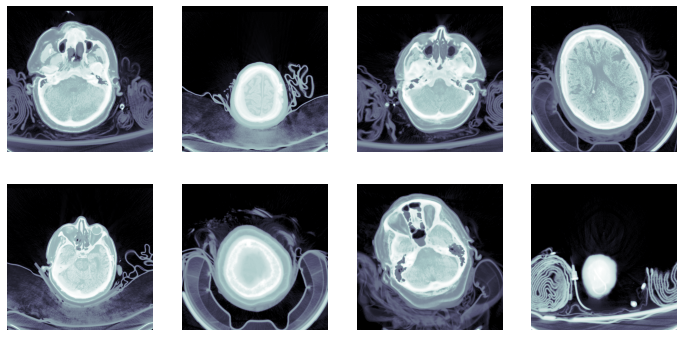

In [48]:
dcms = df2dcm(df_iffy)
dcms.map(fix_pxrepr)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): dcms[i].show(ax=ax)

Images look better following our repair work 

## Remove useless images

To remove 'not so useful' images we will identify what % of pixel of an images is in the brain window (0, 80). This is already in the dataframe we created earlier under `img_pct_window`. 

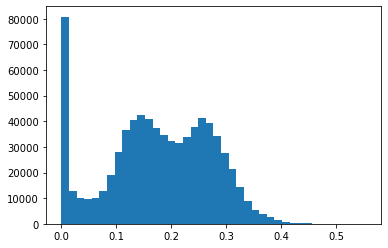

In [49]:
plt.hist(comb.img_pct_window,40);

In [50]:
comb = comb.assign(pct_cut = pd.cut(comb.img_pct_window, [0,0.02,0.05,0.1,0.2,0.3,1]))
comb.pivot_table(values='any', index='pct_cut', aggfunc=['sum','count']).T

pct_cut    (0.0, 0.02]  (0.02, 0.05]  (0.05, 0.1]  (0.1, 0.2]  (0.2, 0.3]  \
sum   any           69           775         3690       23411       61741   
count any        79144         22217        50928      269727      255338   

pct_cut    (0.3, 1.0]  
sum   any       18246  
count any       67315

We can see that images with little brain tissue (<2% of pixels) have almost no labels. So we will remove them.

In [51]:
comb.drop(comb.query('img_pct_window<0.02').index, inplace=True)

## Resample to 2/3 split

In [52]:
df_lbl = comb.query('any==True')
n_lbl = len(df_lbl)
n_lbl

107863

In [53]:
df_nonlbl = comb.query('any==False').sample(n_lbl//2)
len(df_nonlbl)

53931

In [54]:
comb = pd.concat([df_lbl,df_nonlbl])
len(comb)

161794

## Crop to just brain area¶


In [55]:
dcm = Path(dcms[10].filename).dcmread()
fix_pxrepr(dcm)

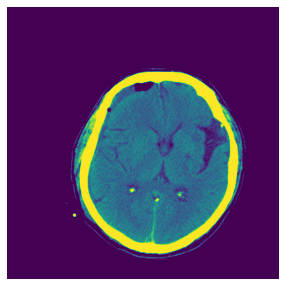

In [56]:
px = dcm.windowed(*dicom_windows.brain)
show_image(px);

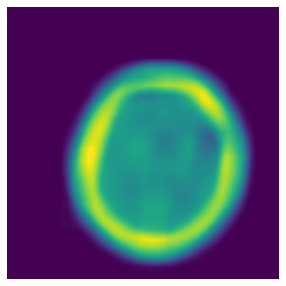

In [57]:
blurred = gauss_blur2d(px, 100)
show_image(blurred);

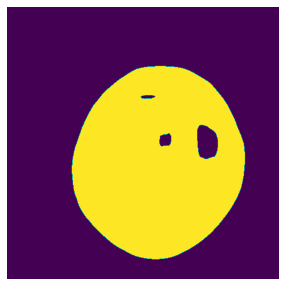

In [58]:
show_image(blurred>0.3);

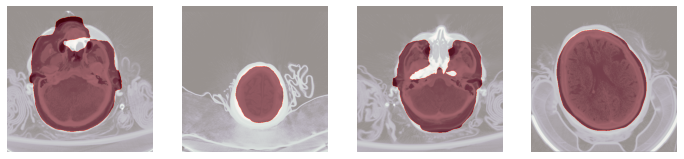

In [59]:
_,axs = subplots(1,4, imsize=3)
for i,ax in enumerate(axs.flat):
    dcms[i].show(dicom_windows.brain, ax=ax)
    show_image(dcms[i].mask_from_blur(dicom_windows.brain), cmap=plt.cm.Reds, alpha=0.6, ax=ax)

In [60]:
def pad_square(x):
    r,c = x.shape
    d = (c-r)/2
    pl,pr,pt,pb = 0,0,0,0
    if d>0: pt,pd = int(math.floor( d)),int(math.ceil( d))        
    else:   pl,pr = int(math.floor(-d)),int(math.ceil(-d))
    return np.pad(x, ((pt,pb),(pl,pr)), 'minimum')

def crop_mask(x):
    mask = x.mask_from_blur(dicom_windows.brain)
    bb = mask2bbox(mask)
    if bb is None: return
    lo,hi = bb
    cropped = x.pixel_array[lo[0]:hi[0],lo[1]:hi[1]]
    return pad_square(cropped)

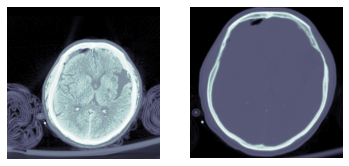

In [61]:
_,axs = subplots(1,2)
dcm.show(ax=axs[0])
dcm_m = PILCTScan.create(crop_mask(dcm))
dcm_m.show(ax=axs[1]);

## Save JPEG images

Now, we will learn to save our smaller images as JPEG for fast prototyping. First, we will sample our dataset to get out `freqhist_bins`. And then use the samples to calculate our bins. 

In [62]:
htypes = 'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'

def get_samples(df):
    recs = [df.query(f'{c}==1').sample() for c in htypes]
    recs.append(df.query('any==0').sample())
    return pd.concat(recs).fname.values

sample_fns = concat(*dfs.map(get_samples))
sample_dcms = tuple(Path(o).dcmread().scaled_px for o in sample_fns)
samples = torch.stack(sample_dcms)
bins = samples.freqhist_bins()

In [63]:
sample_fns.shape

(21,)

In [64]:
bins, bins.shape

(tensor([-3024., -2048., -1014., -1007., -1005., -1004., -1003., -1002., -1001.,
         -1000.,  -999.,  -998.,  -997.,  -995.,  -994.,  -993.,  -991.,  -990.,
          -988.,  -985.,  -981.,  -977.,  -973.,  -970.,  -967.,  -964.,  -960.,
          -956.,  -951.,  -945.,  -936.,  -924.,  -909.,  -891.,  -866.,  -835.,
          -801.,  -758.,  -691.,  -574.,  -351.,  -126.,   -70.,   -41.,   -15.,
             4.,    11.,    17.,    21.,    23.,    25.,    26.,    27.,    28.,
            29.,    30.,    31.,    32.,    33.,    34.,    35.,    36.,    37.,
            38.,    40.,    43.,    48.,    59.,    81.,   164.,   284.,   397.,
           607.,   788.,   958.,  1152.,  1390.,  1656.]),
 torch.Size([78]))

In [65]:
with open(f"{path_dest}/bin.pkl", "wb") as output_file:
    pickle.dump(bins, output_file)

Next, we will make a function to read a single `dcm` file and then fixes them using the `fix_pxrepr` funtion we create earlier. 

In [66]:
def dcm_tfm(fn): 
    fn = Path(fn)
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    return x.scaled_px

We will then make fastai's `TfmDL` to use parallel processing to process the images.

In [67]:
comb.fname.values

array(['../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_9ef779a18.dcm',
       '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_ba857d33f.dcm',
       '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_9dcc748d1.dcm',
       ...,
       '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_8e9f72f61.dcm',
       '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_240b4c94d.dcm',
       '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_515ceb460.dcm'],
      dtype=object)

In [68]:
fns = list(comb.fname.values)
dest = path_dest/'train_jpg'
dest.mkdir(exist_ok=True)
# NB: Use bs=512 or 1024 when running on GPU
bs=4

ds = Datasets(fns, [[dcm_tfm],[os.path.basename]])
dl = TfmdDL(ds, bs=bs, num_workers=2)

As we can see below, the dataloader will return a tuple of `scaled_px` and its corresponding filename. 

In [69]:
dl.one_batch()

(tensor([[[-3024., -3024., -3024.,  ..., -3024., -3024., -3024.],
          [-3024., -3024., -3024.,  ..., -3024., -3024., -3024.],
          [-3024., -3024., -3024.,  ..., -3024., -3024., -3024.],
          ...,
          [-3024., -3024., -3024.,  ..., -3024., -3024., -3024.],
          [-3024., -3024., -3024.,  ..., -3024., -3024., -3024.],
          [-3024., -3024., -3024.,  ..., -3024., -3024., -3024.]],
 
         [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1005., -1003., -1000.,  ..., -1004., -1001.,  -999.],
          ...,
          [ -953.,  -953.,  -959.,  ...,  -553.,  -620.,  -688.],
          [ -955.,  -959.,  -961.,  ...,  -752.,  -796.,  -830.],
          [ -961.,  -962.,  -959.,  ...,  -872.,  -890.,  -903.]],
 
         [[-2048., -2048., -2048.,  ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048.,  ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048.,  ...,

The following functions return output filename and save the cropped `.jpg` files. 

In [70]:
def dest_fname(fname): return dest/Path(fname).with_suffix('.jpg')

def save_cropped_jpg(o, dest):
    fname,px = o
    px.save_jpg(dest_fname(fname), [dicom_windows.brain, dicom_windows.subdural], bins=bins)

In the next function, we make the following
1. move the pixels from dataloader to device
2. make our masks for cropping only the brain portion
3. then make the crop
4. use parallel funtioality to save the images. The `save_jpg` will save brain window, subdural wondow and normalised. Each as one chanel.

In [71]:
def process_batch(pxs, fnames, n_workers=4):
    pxs = to_device(pxs)
    masks = pxs.mask_from_blur(dicom_windows.brain)
    bbs = mask2bbox(masks)
    gs = crop_resize(pxs, bbs, 256).cpu().squeeze()
    parallel(save_cropped_jpg, zip(fnames, gs), n_workers=n_workers, progress=False, dest=dest)

In [72]:
%time process_batch(*dl.one_batch(), n_workers=3)

CPU times: user 63.6 ms, sys: 130 ms, total: 194 ms
Wall time: 373 ms


Let's open and see one of the images. 

In [73]:
fn = dest.ls()[0]
im = Image.open(fn)
fn

Path('train_jpg/ID_ba857d33f.jpg')

As can be seen below, each channel in the saved `jpg` corresponds to brain window, subdural window and normalized. 

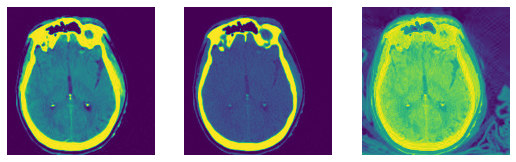

In [74]:
axs = subplots(1, 3)[1].flat
for i, ax in zip(tensor(im).permute(2,0,1), axs):
    ax.imshow(i)
    ax.axis('off')

The above can be simply shown using `fastai` functionality.

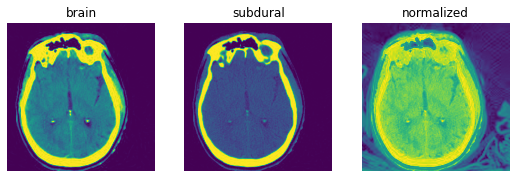

In [75]:
show_images(tensor(im).permute(2,0,1), titles=['brain','subdural','normalized'])

In [76]:
#to make our dataset for protyping. Uncomment the below and execute the cell
#dest.mkdir(exist_ok=True)
#for b in progress_bar(dl): process_batch(*b, n_workers=8)

# Building a classifier

For this part, we will be following some part of Jeremy's 5th notebook. For the full version, please refer to Jeremy's notebook.


In [77]:
df_comb = comb.set_index('SOPInstanceUID')
df_tst = pd.read_feather(path_df/'df_tst.fth')

The next two functions are what we looked in the previous section. We will use the `fix_pxrepr` function to fix the `PixelRepresentation` issue we encountered. And make a 3-channel image using brain window, subdural window and normalised image using the `freq_his` bins we developed earlier.  

In [78]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

In [79]:
def dcm_tfm(fn): 
    fn = (path_trn/fn).with_suffix('.dcm')
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    px = x.scaled_px
    return TensorImage(px.to_3chan(dicom_windows.brain,dicom_windows.subdural, bins=bins))

Let's make a split based on PatientID

In [81]:
set_seed(42)
patients = df_comb.PatientID.unique()
pat_mask = np.random.random(len(patients))<0.8
pat_trn = patients[pat_mask]

In [82]:
def split_data(df):
    idx = L.range(df)
    mask = df.PatientID.isin(pat_trn)
    return idx[mask],idx[~mask]

splits = split_data(df_comb)

`filename` function returns the filename while `fn2image` opens the filename and returns `PILDicom` object

In [88]:
def filename(o): return os.path.splitext(os.path.basename(o))[0]

fns = L(list(df_comb.fname)).map(filename)
fn = fns[0]
fn

'ID_9ef779a18'

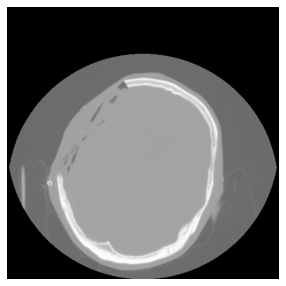

In [89]:
def fn2image(fn): return PILDicom.create((path_trn/fn).with_suffix('.dcm'))
fn2image(fn).show();

`fnlabel` return the labels given a filename

In [90]:
htypes = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
def fn2label(fn): return df_comb.loc[fn][htypes].values.astype(np.float32)
fn2label(fn)

array([1., 0., 1., 0., 1., 1.], dtype=float32)

`get_loss` prepares the weighted loss fuction 

In [93]:
def get_loss(scale=1.0):
    loss_weights = tensor(2.0, 1, 1, 1, 1, 1).cuda()*scale
    return BaseLoss(nn.BCEWithLogitsLoss, pos_weight=loss_weights, floatify=True, flatten=False, 
        is_2d=False)

`accuracy_any` calculates the accuracy for `any` label

In [94]:
def accuracy_any(inp, targ, thresh=0.5, sigmoid=True):
    inp,targ = flatten_check(inp[:,0],targ[:,0])
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [95]:
loss_func = get_loss(0.14*2)
opt_func = partial(Adam, wd=0.01, eps=1e-3)
metrics=[accuracy_multi,accuracy_any]

Next, we will need to prepare the dataloaders. 

First, we will need the transformations necessary to open/prepare (we will us `dcm_tfm`) the images and prepare the labels (we will use `fn2label` followed by `EncodedMultiCategorize` which makes one-hot encoded multi-category labels). 

In [125]:
tfms = [[dcm_tfm], [fn2label, EncodedMultiCategorize(htypes)]]
dls = Datasets(fns, tfms, splits=splits)
nrm = Normalize(tensor([0.6]),tensor([0.25]))
aug = aug_transforms(p_lighting=0.)
batch_tfms = [nrm, *aug]

In [126]:
def get_data(bs, sz):
    return dls.dataloaders(bs=bs, num_workers=nw, 
                           after_item=[ToTensor],
                           after_batch=batch_tfms+[AffineCoordTfm(size=sz)])

(64, 3, 256, 256)

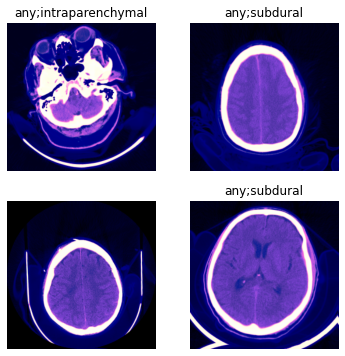

In [129]:
dbch = get_data(64,256)
x,y = dbch.one_batch()
dbch.show_batch(max_n=4)
x.shape

In [128]:
bs = 32
sz=128

In [122]:
def get_learner(bs, sz):
    dls = get_data(bs,sz)
    learn = cnn_learner(dls, 
                        xresnet50, 
                        loss_func=loss_func, 
                        opt_func=opt_func, 
                        metrics=metrics)
    return learn.to_fp16()

In [123]:
learn = get_learner(bs, sz)

In [ ]:
learn.fit_one_cycle(1, 1e-3)

This concludes the amazing series of notebooks by Jeremy! 

References

https://www.kaggle.com/jhoward/creating-a-metadata-dataframe-fastai

https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai

https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai

https://blog.kitware.com/dicom-rescale-intercept-rescale-slope-and-itk/#:~:text=What%20is%20Rescale%20Intercept%20%2F%20Rescale,to%20their%20in%20memory%20representation.